In [439]:
import pandas as pd
import numpy as np


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from nltk.tokenize import word_tokenize

import nltk
from nltk.stem.snowball import SnowballStemmer
from gensim.corpora.dictionary import Dictionary

import matplotlib.pyplot as plt
import seaborn as sns
import re

import json
import string

from PIL import Image
from wordcloud import WordCloud

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold, GridSearchCV

from razdel import tokenize

import pymorphy2
pd.options.mode.chained_assignment = None
stemmer = SnowballStemmer("russian")
from gensim.corpora.dictionary import Dictionary
morph = pymorphy2.MorphAnalyzer()
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [440]:
DATASET_PATH = r'C:\Users\okruz\Downloads\nlp_test_task_2022\dataset\train.tsv'
TEST_DATASET_PATH = r'C:\Users\okruz\Downloads\nlp_test_task_2022\dataset\test.tsv'
df = pd.read_csv(DATASET_PATH, sep='\t')
test_df = pd.read_csv(TEST_DATASET_PATH, sep='\t')

In [441]:
#проверяем датасет на сбалансированность
df.is_fake.value_counts()

0    2879
1    2879
Name: is_fake, dtype: int64

In [442]:
#проверяем датасет на дупликаты
df.loc[df.duplicated()]

,title,is_fake
624,В США зафиксировано рекордное количество банкр...,0


In [443]:
#избавляемся от дупликатов
df.drop_duplicates(inplace=True, keep='last')
df = df.reset_index(drop=True)

<AxesSubplot:xlabel='len', ylabel='Count'>

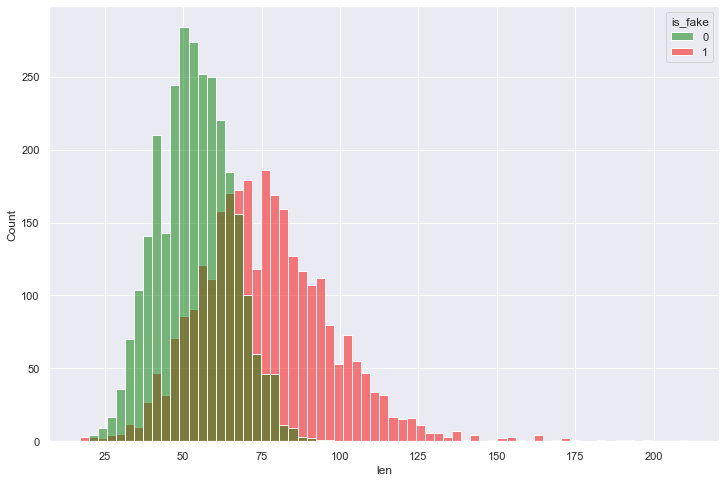

In [444]:
#смотрим на распределение по количеству символов в название
sns.set(rc={'figure.figsize':(12,8)})
df['len'] = df['title'].copy().apply(len)
sns.histplot(data = df, 
              x='len', 
              hue='is_fake', 
              palette = ['green', 'red'],
              alpha=0.5,
              kde=False)

In [445]:
#можем заметить, что в фейковых новостях символов больше. У реальных новостей количество символов не превышает 100

<AxesSubplot:xlabel='len', ylabel='Density'>

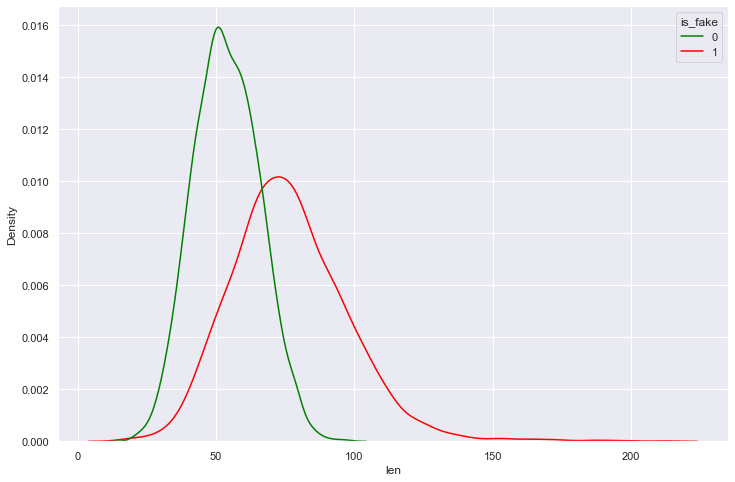

In [446]:
def len_words(text):
    
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]
    
    return len(words)

df['len_word'] = df['title'].apply(lambda x: len_words(x), 1)
sns.kdeplot(data = df, 
              x='len', 
              hue='is_fake', 
              palette = ['green', 'red'],
              alpha=0.5)

In [447]:
#также заметна разница и по количеству слов, в фейковых новостях их заметно больше

In [448]:
#токенизируем текст и убираем окончания слов
def text_modify(text):
    
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]
    
    text=[stemmer.stem(word) for word in words]
    
    return text

In [449]:
df['title'] = df['title'].apply(lambda x: text_modify(x), 1)
test_df['title'] = test_df['title'].apply(lambda x: text_modify(x), 1)

In [450]:
'''отдельно считаем сколько раз слово встречалось в фейковых новостях и в настоящих. Затем вводим параметр фейковости слова.
Чем чаще слово встречалось в фейковых новостях, тем значение больше. Если слово больше встречалось в реальных новостях, то
значение отрицательное и, соответственно, также зависит от того, насколько чаще оно встречалось в реальных новостях
'''

def fake_rate(df):
    df_fake = df.query('is_fake == 1').reset_index(drop=True)
    df_real = df.query('is_fake == 0').reset_index(drop=True)
    
    for i in range(len(df_real['title'])):
        df_real['title'][i] = ' '.join(df_real['title'][i])
    
    for i in range(len(df_fake['title'])):
        df_fake['title'][i] = ' '.join(df_fake['title'][i])
        
    text_fake = np.array(df_fake.title.values)
    text_real = np.array(df_real.title.values)
    
    text_fake = " ".join(text_fake)
    text_real = " ".join(text_real)
    
    text_fake = text_fake.split()
    text_real = text_real.split()
    
    from collections import Counter
    Counter = Counter(text_fake)
    count_fake = Counter.most_common()
    
    from collections import Counter
    Counter = Counter(text_real)
    count_real = Counter.most_common()
    
    df_real = pd.DataFrame(count_real, columns =['Name', 'freq_norm'])
    df_fake = pd.DataFrame(count_fake, columns =['Name', 'freq_fake'])
    
    merged_df = pd.merge(df_fake, df_real, on="Name", how='outer')
    merged_df = merged_df.fillna(0)
    merged_df['fake_rate'] = 0.0
    
    for i in range(len(merged_df)):
        if merged_df['freq_fake'][i] > merged_df['freq_norm'][i]:
            merged_df['fake_rate'][i] = ((merged_df['freq_fake'][i]+1) - (merged_df['freq_norm'][i]+1))/(merged_df['freq_norm'][i]+1)
        else:
            merged_df['fake_rate'][i] = -((merged_df['freq_norm'][i]+1) - (merged_df['freq_fake'][i]+1))/(merged_df['freq_fake'][i]+1)
            
    return merged_df
    
    
    

In [451]:
fr_df = fake_rate(df)

In [452]:
#посмотрим какие слова чаще всего встречались в реальных новостях
fr_df.sort_values('fake_rate').head(20)

,Name,freq_fake,freq_norm,fake_rate
7485,спартак,0.0,28.0,-28.000000
7486,нхл,0.0,24.0,-24.000000
7487,кубк,0.0,21.0,-21.000000
5317,нефт,1.0,42.0,-20.500000
7488,цска,0.0,19.0,-19.000000
7489,динам,0.0,18.0,-18.000000
7490,режиссер,0.0,16.0,-16.000000
7491,барселон,0.0,16.0,-16.000000
7492,боксер,0.0,16.0,-16.000000
7493,англ,0.0,15.0,-15.000000


In [453]:
#посмотрим какие слова чаще всего встречались в реальных новостях
fr_df.sort_values('fake_rate').tail(20)

,Name,freq_fake,freq_norm,fake_rate
189,собянин,19.0,0.0,19.0
179,%,20.0,0.0,20.0
174,гражда,20.0,0.0,20.0
175,вакцинирова,20.0,0.0,20.0
171,*,20.0,0.0,20.0
167,ответствен,21.0,0.0,21.0
166,граждан,21.0,0.0,21.0
158,введут,21.0,0.0,21.0
4,",",666.0,28.0,22.0
117,млн,26.0,0.0,26.0


 1) фейковые новости в основном про политику и короновирус  
 2) нет фейковых новостей о спорте  
 3) в фейковых новостях намного чаще используется пунктуация и другие спецсимволы  


In [454]:
#создаем словарь, в котором будут слова и их показатель фейковости
word_dict = dict(zip(fr_df.Name, fr_df.fake_rate))

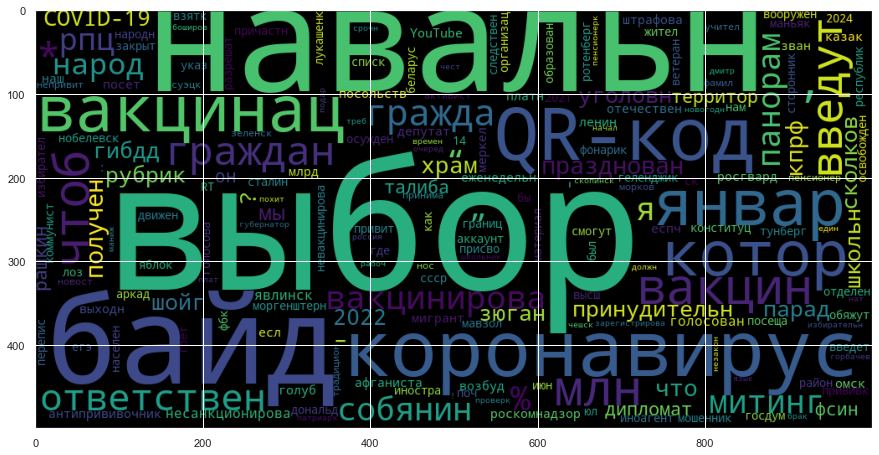

In [455]:
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)

In [456]:
#создаем вектроное представление каждого заголовка
def vect(title):
    vector = []
    for key in word_dict:
        if key in title:
            vector.append(word_dict[key])
        else:
            vector.append(0.0)
    return vector

In [457]:
df['title'] = df['title'].apply(lambda x: vect(x), 1)
test_df['title'] = test_df['title'].apply(lambda x: vect(x), 1)

X = df[['title']]
test_df_x = test_df[['title']]

y = df['is_fake']

X = [X, pd.DataFrame(X['title'].tolist())]
test_df_x = [test_df_x, pd.DataFrame(test_df_x['title'].tolist())]

X = pd.concat(X, axis=1).drop('title', axis=1)
test_df_x = pd.concat(test_df_x, axis=1).drop('title', axis=1)

In [458]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y.values.ravel(), test_size = 0.1, stratify=y, random_state=2)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, Y_train)

LogisticRegression(max_iter=1000)

In [459]:
preds = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(Y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.348935, F-Score=0.889, Precision=0.878, Recall=0.899


In [460]:
cv_score = cross_val_score(model, X_train, Y_train, scoring='f1', cv=KFold(n_splits=10, shuffle=True, random_state=20))
cv_score.mean()

0.8905580109256288

In [461]:
test_predictions = model.predict(test_df_x)
predictions = pd.read_csv(TEST_DATASET_PATH, sep='\t')
predictions['is_fake'] = test_predictions
predictions.to_csv(r'C:\Users\okruz\Downloads\Okruzhnov_Sergei\predictions.tsv', index=False)
predictions.head()

,title,is_fake
0,Роскомнадзор представил реестр сочетаний цвето...,1
1,Ночью под Минском на президентской горе Белара...,1
2,Бывший спичрайтер Юрия Лозы рассказал о трудно...,1
3,"Сельская церковь, собравшая рекордно низкое ко...",1
4,Акции Google рухнули после объявления о переза...,0


In [462]:
predictions.is_fake.value_counts()

0    536
1    464
Name: is_fake, dtype: int64

In [ ]:
pip freeze > requirements.txt